<a href="https://colab.research.google.com/github/AlejandroPinedo/2025_UTEC_PROGRAMACION_101/blob/main/FinalProject_IAFUNDAMENTALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalación de Librerías
!pip install pandas numpy scikit-learn imbalanced-learn shap matplotlib seaborn

In [2]:
# Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocesamiento y Modelado ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Modelos ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# --- Métricas y Explicabilidad ---
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import shap

# --- Configuraciones Globales ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
RANDOM_STATE = 42

In [3]:
# Carga de Datos
print("--- 1. Carga de Datos ---")
url = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'
df = pd.read_csv(url)
print(f"✅ Dataset cargado con éxito. Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas.")
print("\nPrimeras 5 filas del dataset:")
print(df.head())
print("-" * 50)

--- 1. Carga de Datos ---
✅ Dataset cargado con éxito. Dimensiones: 768 filas, 9 columnas.

Primeras 5 filas del dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
--------------------------------------------------



--- 2. Análisis Exploratorio de Datos (EDA) ---

📊 Distribución de la variable objetivo (Outcome):
   No Diabetes (0): 65.10%
   Diabetes (1):    34.90%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


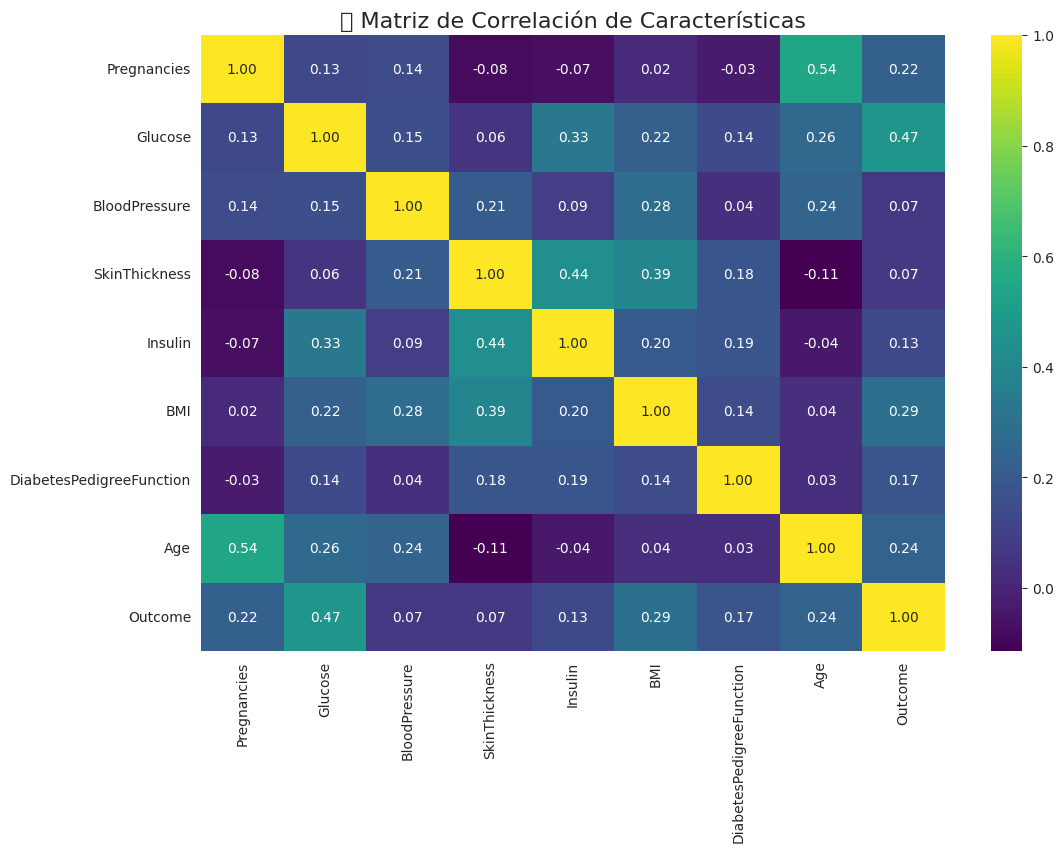

--------------------------------------------------


In [4]:
# Análisis Exploratorio Básico (EDA)
print("\n--- 2. Análisis Exploratorio de Datos (EDA) ---")
print("\n📊 Distribución de la variable objetivo (Outcome):")
outcome_dist = df['Outcome'].value_counts(normalize=True)
print(f"   No Diabetes (0): {outcome_dist.get(0,0):.2%}")
print(f"   Diabetes (1):    {outcome_dist.get(1,0):.2%}")

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('🔗 Matriz de Correlación de Características', fontsize=16)
plt.show()
print("-" * 50)

In [5]:
# Preprocesamiento y Limpieza de Datos
print("\n--- 3. Preprocesamiento de Datos ---")
cols_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("🛠️ Imputando valores '0' con la mediana de cada columna...")
for col in cols_to_impute:
    df[col] = df[col].replace(0, np.nan)
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
print("✅ Imputación finalizada.")

X = df.drop('Outcome', axis=1)
y = df['Outcome']

print("\n⚖️ Aplicando escalado z-score (StandardScaler)...")
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print("✅ Escalado finalizado.")

print("\n✂️ Dividiendo datos (80% train, 20% test) de forma estratificada...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print(f"✅ División completa: {X_train.shape[0]} muestras de entrenamiento, {X_test.shape[0]} de prueba.")
print("-" * 50)


--- 3. Preprocesamiento de Datos ---
🛠️ Imputando valores '0' con la mediana de cada columna...
✅ Imputación finalizada.

⚖️ Aplicando escalado z-score (StandardScaler)...
✅ Escalado finalizado.

✂️ Dividiendo datos (80% train, 20% test) de forma estratificada...
✅ División completa: 614 muestras de entrenamiento, 154 de prueba.
--------------------------------------------------


In [6]:
# Definición de Modelos y Pipelines
print("\n--- 4. Definición de Modelos y Pipelines ---")
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
}
print("✅ Modelos base definidos:", list(models.keys()))
print("-" * 50)


--- 4. Definición de Modelos y Pipelines ---
✅ Modelos base definidos: ['LogisticRegression', 'KNN', 'RandomForest', 'SVM']
--------------------------------------------------


In [20]:
# Experimentos de Validación Cruzada (con y sin SMOTE)
print("\n--- 5. Experimentos: Validación Cruzada (CV) ---")
def evaluate_models_cv(models_dict, X, y, use_smote=False):
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scoring = ['accuracy', 'recall', 'f1_weighted', 'roc_auc']

    for name, model in models_dict.items():
        pipeline = ImbPipeline([('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', model)]) if use_smote else model
        scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
        results[name] = {
            'Precisión (μ)': np.mean(scores['test_accuracy']),
            'Recall (μ)': np.mean(scores['test_recall']),
            'F1-Score (μ)': np.mean(scores['test_f1_weighted']),
            'AUC (μ)': np.mean(scores['test_roc_auc'])
        }
    return pd.DataFrame(results).T.round(3)

print("\n🔄 Resultados de CV (5-fold) SIN SMOTE (Baseline):")
cv_results_no_smote = evaluate_models_cv(models, X_train, y_train, use_smote=False)
print(cv_results_no_smote)

print("\n🔄 Resultados de CV (5-fold) CON SMOTE:")
cv_results_with_smote = evaluate_models_cv(models, X_train, y_train, use_smote=True)
print(cv_results_with_smote)
print("-" * 50)


--- 5. Experimentos: Validación Cruzada (CV) ---

🔄 Resultados de CV (5-fold) SIN SMOTE (Baseline):
                    Precisión (μ)  Recall (μ)  F1-Score (μ)  AUC (μ)
LogisticRegression          0.787       0.570         0.778    0.843
KNN                         0.733       0.561         0.729    0.784
RandomForest                0.767       0.589         0.762    0.819
SVM                         0.775       0.570         0.767    0.834

🔄 Resultados de CV (5-fold) CON SMOTE:
                    Precisión (μ)  Recall (μ)  F1-Score (μ)  AUC (μ)
LogisticRegression          0.769       0.715         0.771    0.844
KNN                         0.718       0.705         0.723    0.788
RandomForest                0.772       0.701         0.773    0.818
SVM                         0.762       0.747         0.765    0.837
--------------------------------------------------



--- 6. Evaluación Final en Test Set y Visualización de Rendimiento de cada Modelo ---

--- 6.1. Visualización del rendimiento del modelo: LogisticRegression ---


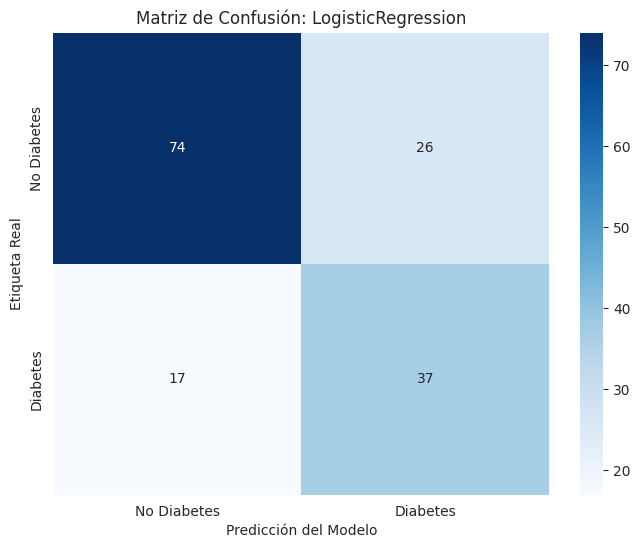

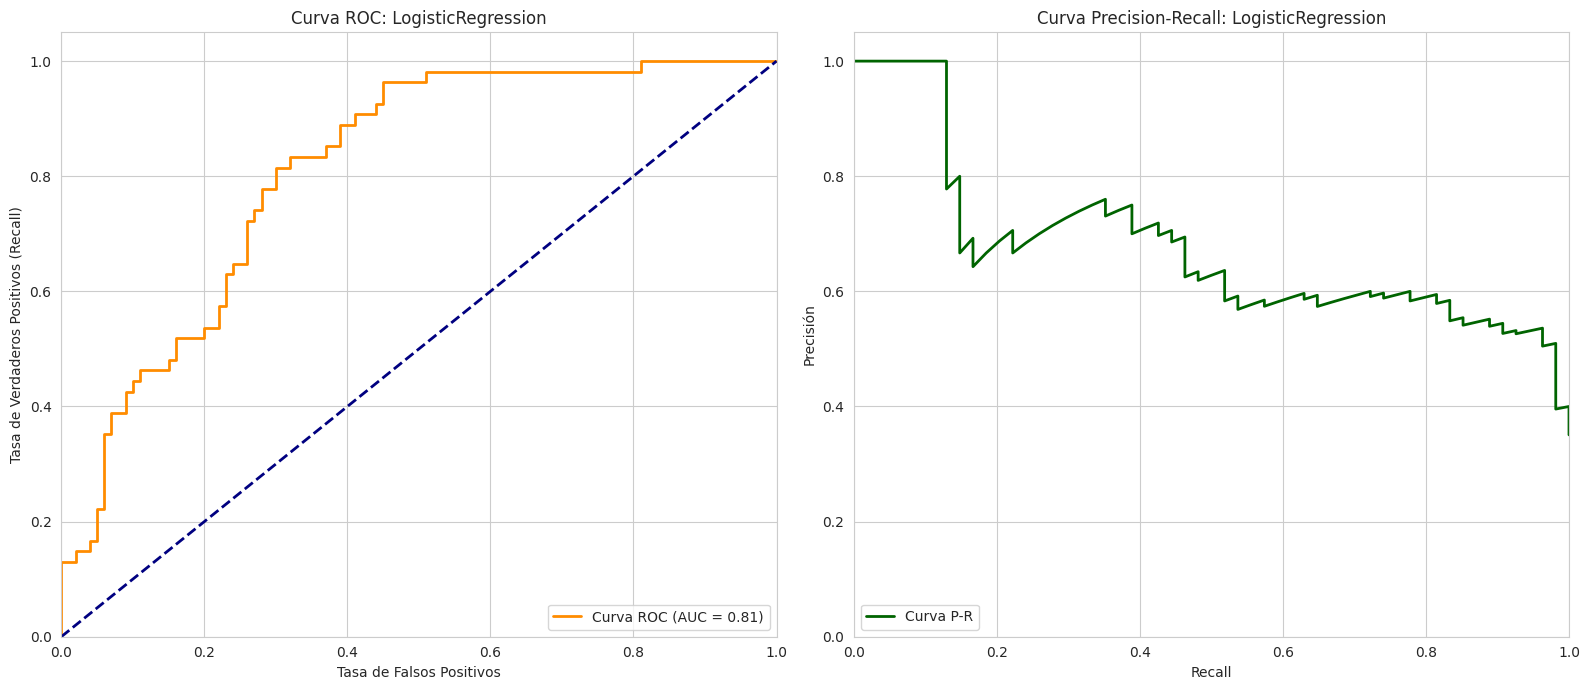

--------------------------------------------------

--- 6.1. Visualización del rendimiento del modelo: KNN ---


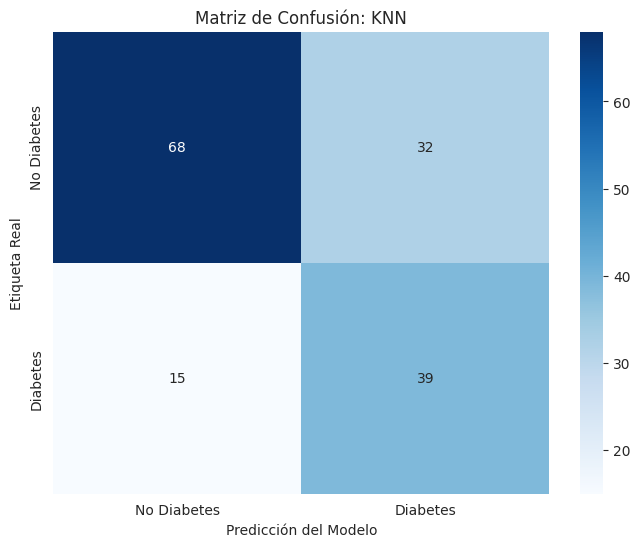

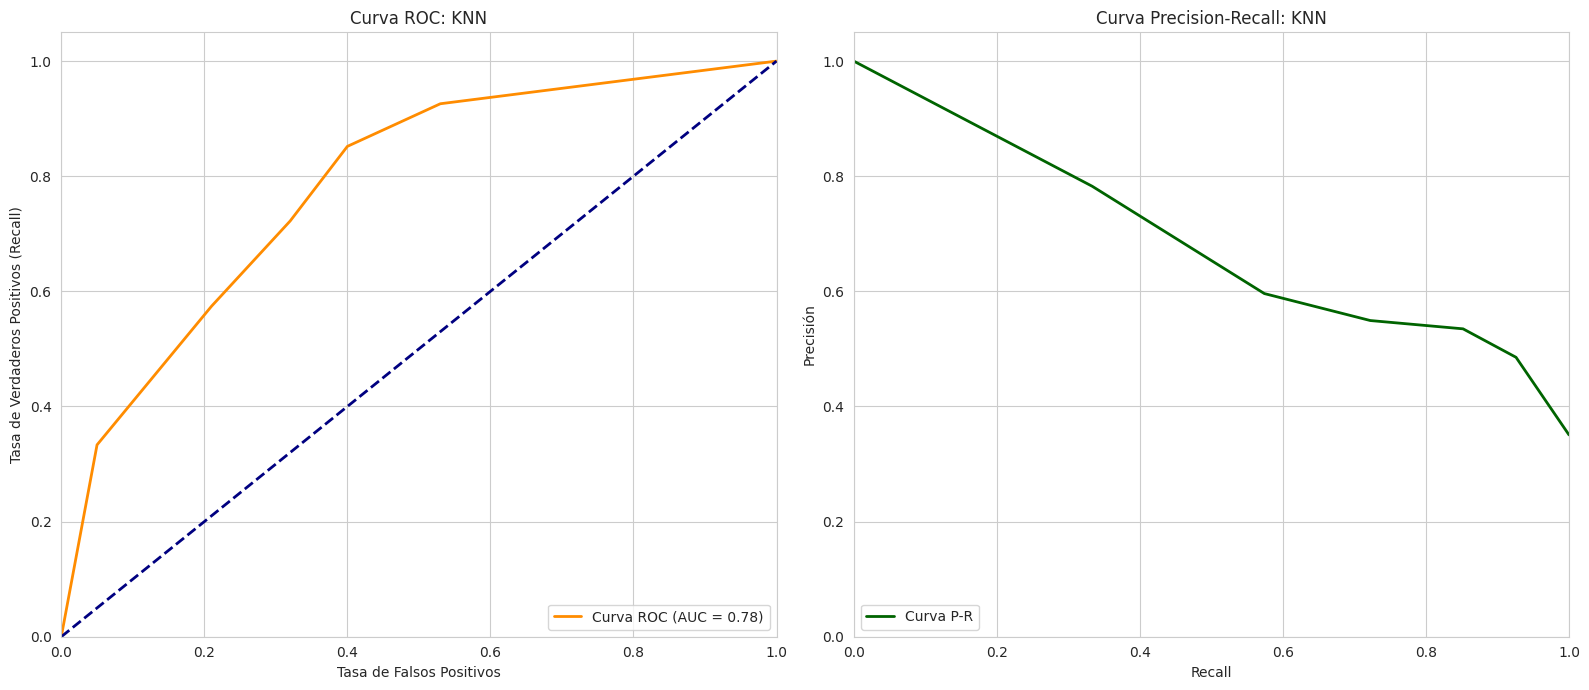

--------------------------------------------------

--- 6.1. Visualización del rendimiento del modelo: RandomForest ---


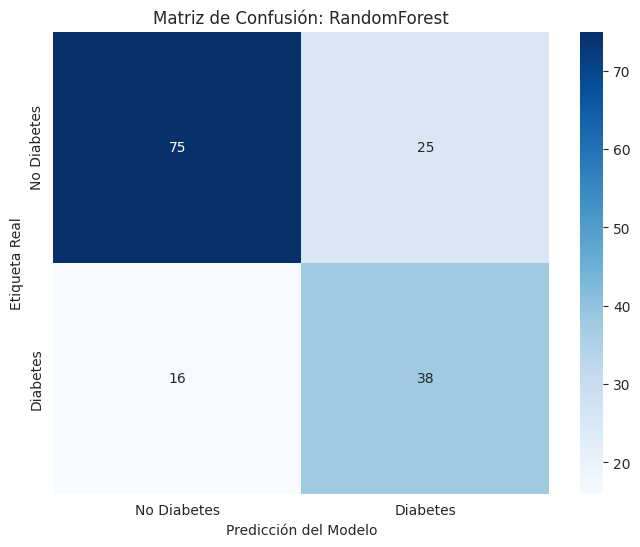

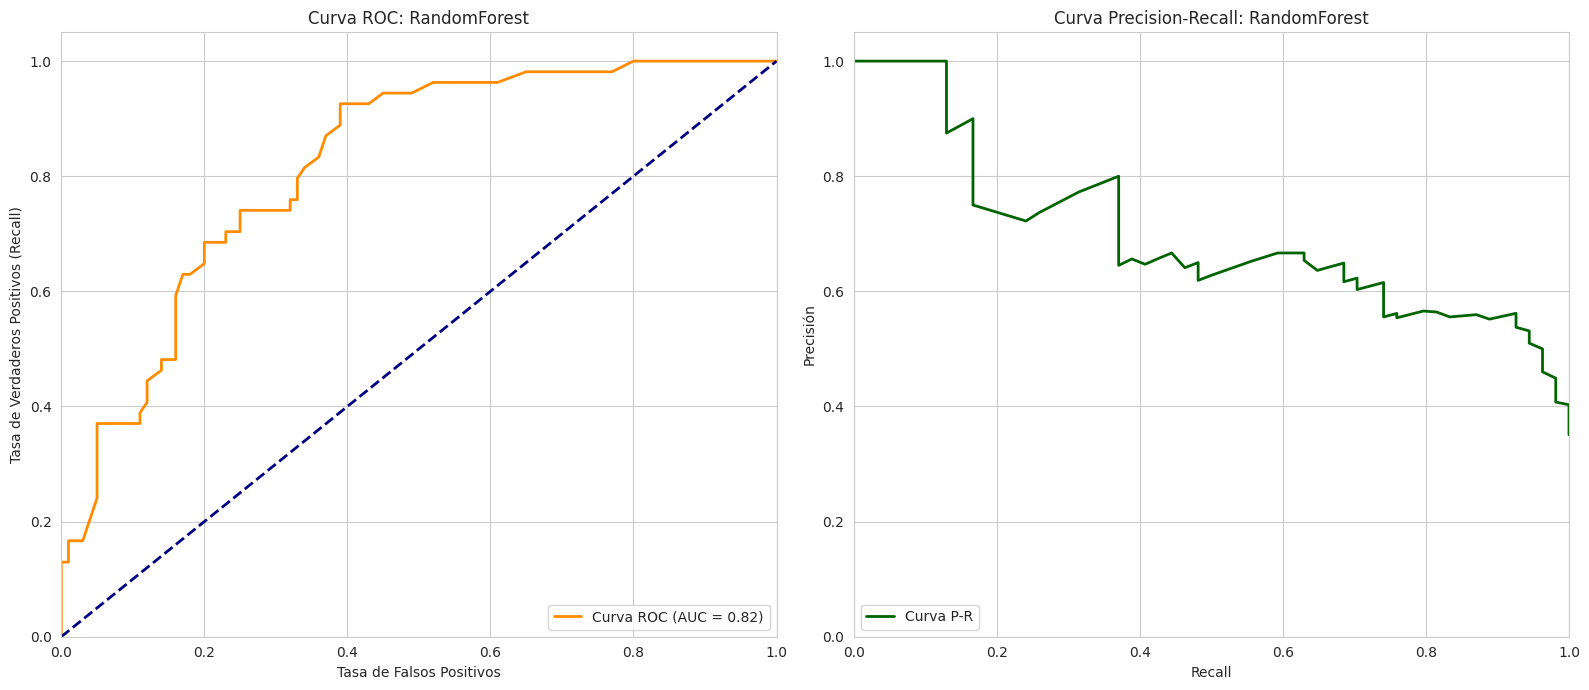

--------------------------------------------------

--- 6.1. Visualización del rendimiento del modelo: SVM ---


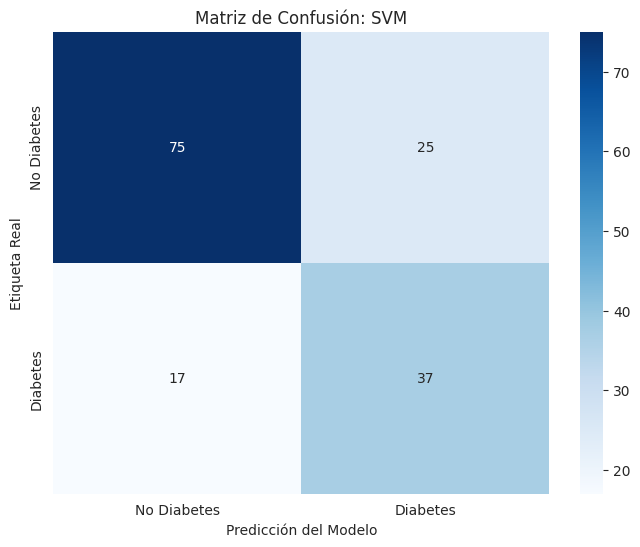

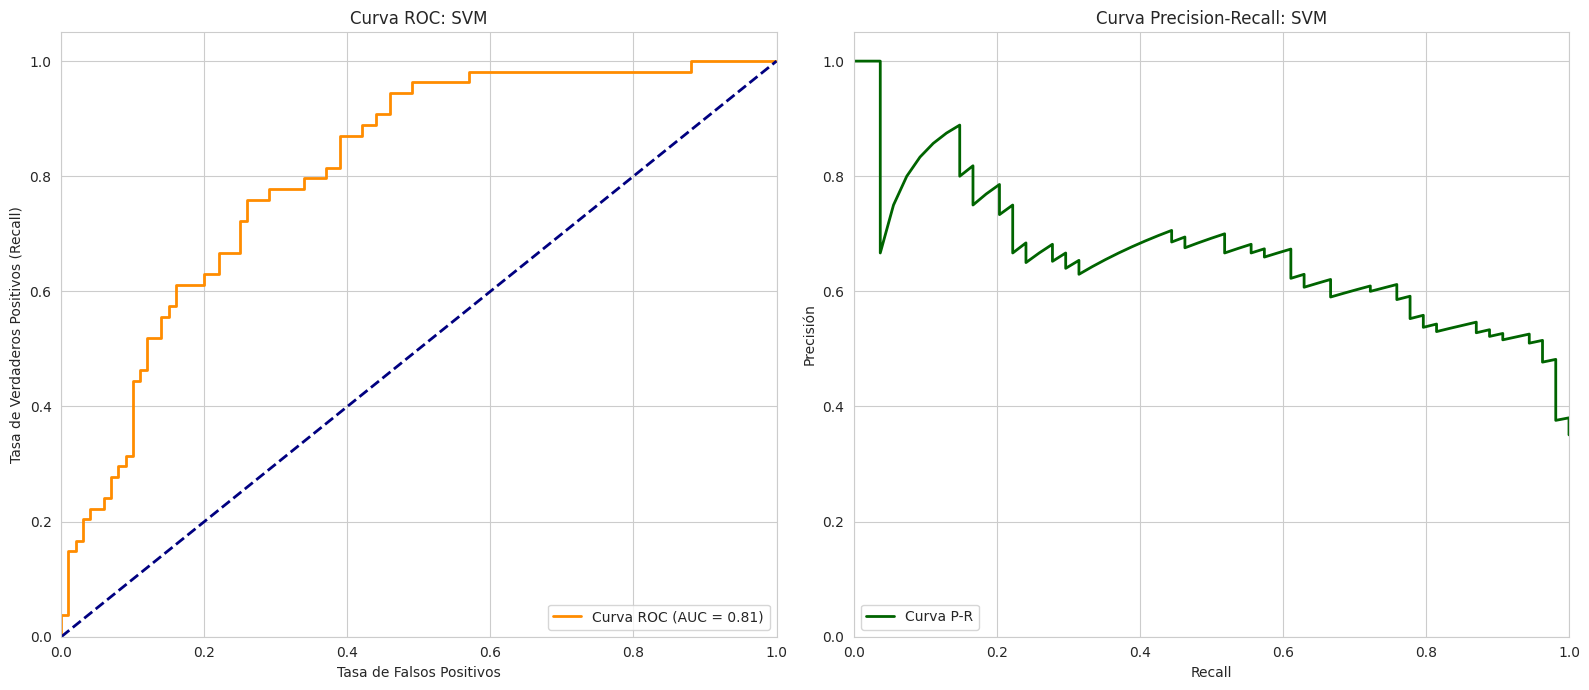

--------------------------------------------------

📊 Resultados finales en el conjunto de prueba (con SMOTE):
                    Precisión  Recall  F1-Score    AUC
Modelo                                                
LogisticRegression      0.721   0.685     0.632  0.811
KNN                     0.695   0.722     0.624  0.783
RandomForest            0.734   0.704     0.650  0.819
SVM                     0.727   0.685     0.638  0.810


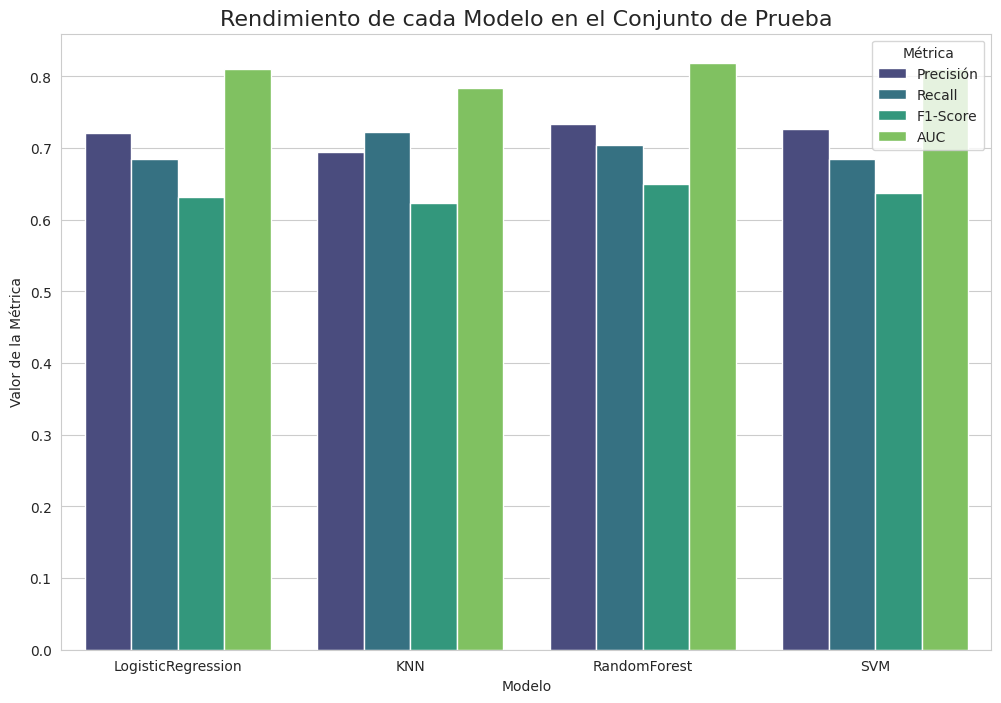

--------------------------------------------------


In [13]:
# Evaluación Final en Test Set y Visualización de Rendimiento de cada Modelo
print("\n--- 6. Evaluación Final en Test Set y Visualización de Rendimiento de cada Modelo ---")
test_results = []
models_with_smote = {}
for name, model in models.items():
    models_with_smote[name] = ImbPipeline([('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', model)])

for name, pipeline in models_with_smote.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    test_results.append({
        'Modelo': name,
        'Precisión': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

    # Generar gráficos para cada modelo
    print(f"\n--- 6.1. Visualización del rendimiento del modelo: {name} ---")

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(f'Matriz de Confusión: {name}')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicción del Modelo')
    plt.show()

    # Curvas ROC y Precision-Recall
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Curva ROC
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('Tasa de Falsos Positivos')
    axes[0].set_ylabel('Tasa de Verdaderos Positivos (Recall)')
    axes[0].set_title(f'Curva ROC: {name}')
    axes[0].legend(loc='lower right')

    # Curva Precision-Recall
    axes[1].plot(recall, precision, color='darkgreen', lw=2, label='Curva P-R')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precisión')
    axes[1].set_title(f'Curva Precision-Recall: {name}')
    axes[1].legend(loc='lower left')

    plt.tight_layout()
    plt.show()
    print("-" * 50)

results_df = pd.DataFrame(test_results).set_index('Modelo')
print("\n📊 Resultados finales en el conjunto de prueba (con SMOTE):")
print(results_df.round(3))

# Visualización del rendimiento de todos los modelos
results_df_plot = results_df.reset_index().melt('Modelo', var_name='Métrica', value_name='Valor')
plt.figure(figsize=(12, 8))
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=results_df_plot, palette='viridis')
plt.title('Rendimiento de cada Modelo en el Conjunto de Prueba', fontsize=16)
plt.xlabel('Modelo')
plt.ylabel('Valor de la Métrica')
plt.legend(title='Métrica')
plt.show()
print("-" * 50)


--- 7. Interpretabilidad con SHAP ---
🧠 Calculando valores SHAP para RandomForest...
📊 Generando gráfico SHAP summary para todas las variables...


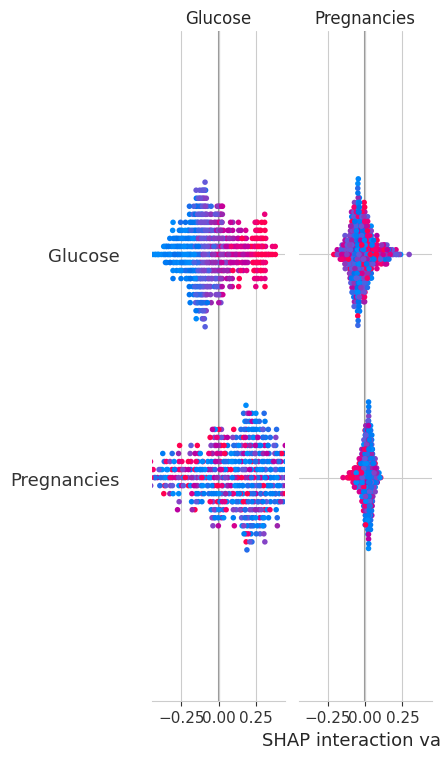

✅ Gráfico SHAP generado con todas las variables.


In [21]:
# In[9]: Interpretabilidad con SHAP
print("\n--- 7. Interpretabilidad con SHAP ---")
print("🧠 Calculando valores SHAP para RandomForest...")

# Creamos explainer para el clasificador RandomForest entrenado
explainer = shap.TreeExplainer(final_rf_pipeline.named_steps['clf'])

# Calculamos shap_values para todas las variables
shap_values = explainer.shap_values(X_train)

# Mostramos todas las variables en el gráfico summary
print("📊 Generando gráfico SHAP summary para todas las variables...")
shap.summary_plot(
    shap_values,
    X_train,
    feature_names=X.columns,
    max_display=len(X.columns)  # Mostrar todas las variables
)

print("✅ Gráfico SHAP generado con todas las variables.")
